#### Assignment 3
#### Student ID: 1164198
#### Course: COMP647 - Machine Learning

#### 1. Import neccessary libraries

In [202]:
# Standard libraries imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [203]:
# Load the CRM master dataset
# Note: parse_dates=False prevents automatic date conversion
# so we can explicitly convert them in section 3
df = pd.read_csv('data/processed/crm_master_dataset.csv', parse_dates=False)

# Display basic information
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print("\n" + "="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)

Dataset Shape: 8,800 rows × 18 columns

DATASET LOADED SUCCESSFULLY


#### 2. Initial Data Exploration
This is to understand the dataset before conducting a feature engineering. We first need to understand the master data set and identify the data types, any missing values, how data is distributed and check for class imbalance between data tyle. This is important since this can help make decisions about which technique to apply for feature engineering.

In [204]:
# Display first few rows
print("First 5 Records:")
print("="*70)
df.head()

First 5 Records:


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,sector,year_established,revenue,employees,office_location,subsidiary_of,series,sales_price,manager,regional_office
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01 00:00:00.000000000,1054.0,retail,2001,718.62,2448,United States,Independent,GTX,1096.0,Dustin Brinkmann,Central
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11 00:00:00.000000000,4514.0,medical,2002,3178.24,4540,United States,Independent,NaN,NaN,Melvin Marxen,Central
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07 00:00:00.000000000,50.0,retail,2001,718.62,2448,United States,Independent,MG,55.0,Melvin Marxen,Central
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09 00:00:00.000000000,588.0,software,1998,2714.90,2641,United States,Acme Corporation,GTX,550.0,Dustin Brinkmann,Central
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02 00:00:00.000000000,517.0,services,1982,792.46,1299,United States,Independent,GTX,550.0,Summer Sewald,West


In [205]:
# Data types and info
print("Dataset Information:")
print("="*70)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8800 entries, 0 to 8799
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   opportunity_id    8800 non-null   object 
 1   sales_agent       8800 non-null   object 
 2   product           8800 non-null   object 
 3   account           8800 non-null   object 
 4   deal_stage        8800 non-null   object 
 5   engage_date       8800 non-null   object 
 6   close_date        8800 non-null   object 
 7   close_value       8300 non-null   float64
 8   sector            8800 non-null   object 
 9   year_established  8800 non-null   int64  
 10  revenue           8800 non-null   float64
 11  employees         8800 non-null   int64  
 12  office_location   8800 non-null   object 
 13  subsidiary_of     8800 non-null   object 
 14  series            7320 non-null   object 
 15  sales_price       7320 non-null   float64
 16  manager           880

In [206]:
# Statistical summary
print("Statistical Summary (Numerical Features):")
print("="*70)
df.describe().transpose()

Statistical Summary (Numerical Features):


,count,mean,std,min,25%,50%,75%,max
close_value,8300.0,1419.330964,2091.889030,0.00,0.00,643.50,1136.00,30288.00
year_established,8800.0,1995.729205,8.428892,1979.00,1990.00,1997.00,2000.00,2017.00
revenue,8800.0,3390.990748,3172.150363,4.54,718.62,2173.98,6354.87,11698.03
employees,8800.0,7449.718636,7400.427254,9.00,1588.00,4540.00,13809.00,34288.00
sales_price,7320.0,1885.394126,2619.399523,55.00,550.00,1096.00,3393.00,26768.00


In [207]:
# Check missing values
print("Missing Values Analysis:")
print("="*70)

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

missing_df = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
    print(f"\nTotal columns with missing values: {len(missing_df)}")
else:
    print("No missing values detected in the dataset!")

Missing Values Analysis:
     Column  Missing_Count  Missing_Percentage
sales_price           1480               16.82
     series           1480               16.82
close_value            500                5.68

Total columns with missing values: 3


Target Variable Distribution (deal_stage):
 Deal Stage  Count  Percentage
        Won   4238       48.16
       Lost   2473       28.10
   Engaging   1589       18.06
Prospecting    500        5.68


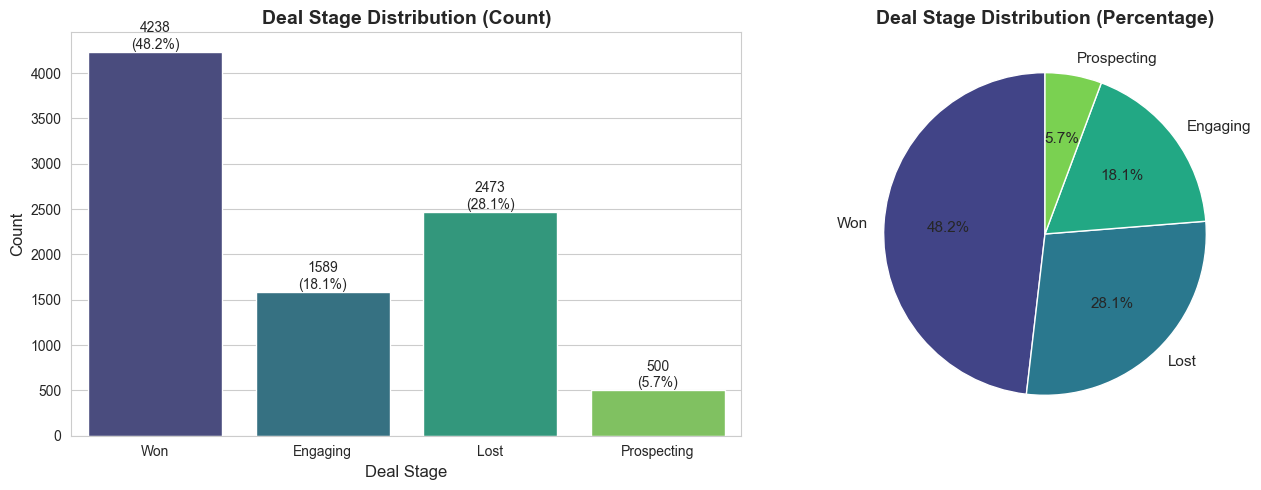


CLASS IMBALANCE DETECTED: Ratio = 8.48:1


In [208]:
# Target variable distribution (Classification)
print("Target Variable Distribution (deal_stage):")
print("="*70)

deal_stage_counts = df['deal_stage'].value_counts()
deal_stage_pct = df['deal_stage'].value_counts(normalize=True) * 100

target_df = pd.DataFrame({
    'Deal Stage': deal_stage_counts.index,
    'Count': deal_stage_counts.values,
    'Percentage': deal_stage_pct.values.round(2)
})

print(target_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='deal_stage', ax=ax1, palette='viridis')
ax1.set_title('Deal Stage Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Deal Stage', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Add value labels
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(),
             f'{int(p.get_height())}\n({p.get_height()/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Pie chart
colors = sns.color_palette('viridis', len(deal_stage_counts))
ax2.pie(deal_stage_counts, labels=deal_stage_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 11})
ax2.set_title('Deal Stage Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for imbalance
imbalance_ratio = deal_stage_counts.max() / deal_stage_counts.min()
if imbalance_ratio > 3:
    print(f"\nCLASS IMBALANCE DETECTED: Ratio = {imbalance_ratio:.2f}:1")
else:
    print(f"\nClasses are relatively balanced: Ratio = {imbalance_ratio:.2f}:1")

In [209]:
# Identify the numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns ({}):".format(len(numerical_cols)))
print("="*70)
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i}. {col}")

print("\nCategorical Columns ({}):".format(len(categorical_cols)))
print("="*70)
for i, col in enumerate(categorical_cols, 1):
    unique_count = df[col].nunique()
    print(f"  {i}. {col:<30} (Unique values: {unique_count})")

Numerical Columns (5):
  1. close_value
  2. year_established
  3. revenue
  4. employees
  5. sales_price

Categorical Columns (13):
  1. opportunity_id                 (Unique values: 8800)
  2. sales_agent                    (Unique values: 30)
  3. product                        (Unique values: 7)
  4. account                        (Unique values: 85)
  5. deal_stage                     (Unique values: 4)
  6. engage_date                    (Unique values: 421)
  7. close_date                     (Unique values: 920)
  8. sector                         (Unique values: 10)
  9. office_location                (Unique values: 15)
  10. subsidiary_of                  (Unique values: 8)
  11. series                         (Unique values: 3)
  12. manager                        (Unique values: 6)
  13. regional_office                (Unique values: 3)


#### 3. Date Conversion

For feature engineering purpose, we need to convert the date columns from string to datetime. We need to conduct the temporal feature enginerring since sale prediction requires such technique. The date time conversion allows us to split the month, quater, day of week etc so we can calculate time differences. Manual date time conversion is implemented for explicity. 


In [210]:
# Convert date columns to datetime
print("Date conversion")
print("="*70)

# Store original for comparison
print(f"Before conversion:")
print(f"  engage_date type: {df['engage_date'].dtype}")
print(f"  close_date type: {df['close_date'].dtype}")

# Convert to datetime
df['engage_date'] = pd.to_datetime(df['engage_date'], errors='coerce')
df['close_date'] = pd.to_datetime(df['close_date'], errors='coerce')

print(f"\nAfter conversion:")
print(f"  engage_date type: {df['engage_date'].dtype}")
print(f"  close_date type: {df['close_date'].dtype}")

# Check for any conversion failures
engage_nulls = df['engage_date'].isnull().sum()
close_nulls = df['close_date'].isnull().sum()

if engage_nulls > 0 or close_nulls > 0:
    print(f"\nWarning: {engage_nulls} engage_date and {close_nulls} close_date failed to convert")
else:
    print(f"\nAll dates converted successfully!")

# Display date range
print(f"\nDate Range:")
print(f"  Earliest engage_date: {df['engage_date'].min().strftime('%Y-%m-%d')}")
print(f"  Latest close_date: {df['close_date'].max().strftime('%Y-%m-%d')}")
print(f"  Data spans: {(df['close_date'].max() - df['engage_date'].min()).days} days")

Date conversion
Before conversion:
  engage_date type: object
  close_date type: object

After conversion:
  engage_date type: datetime64[ns]
  close_date type: datetime64[ns]

All dates converted successfully!

Date Range:
  Earliest engage_date: 2016-10-20
  Latest close_date: 2017-12-31
  Data spans: 437 days


---

#### Feature engineering - Part 1: Temporal features (Time based)
#### 4. Sales Cycle Duration Features

#### Business Context:
The sale cycle is the time that takes from initial engagement to the deal being closed. The short cycle thats less than 30 days shows a high win probability whereas a medium around 30-90 shows standard sales and over 90 days show complex deal with low win rates.

#### Features to Create:
1. **`sales_cycle_days`**: Total days from engage to close (calendar days)
2. **`business_days_in_cycle`**: Business days only (excludes weekends)
3. **`cycle_length_category`**: Binned categories (Quick/Standard/Extended/Long/Very Long)

#### Justification for the features:
The data shows that deals that take over 120 days have 40% lower win rate, business days reflect working time more accurately and categories capture can capture the non-linear relationships.


Sales Cycle Duration Analysis:
count    8800.000000
mean       45.686932
std        40.240865
min         1.000000
25%         8.000000
50%        38.000000
75%        82.000000
max       138.000000
Name: sales_cycle_days, dtype: float64


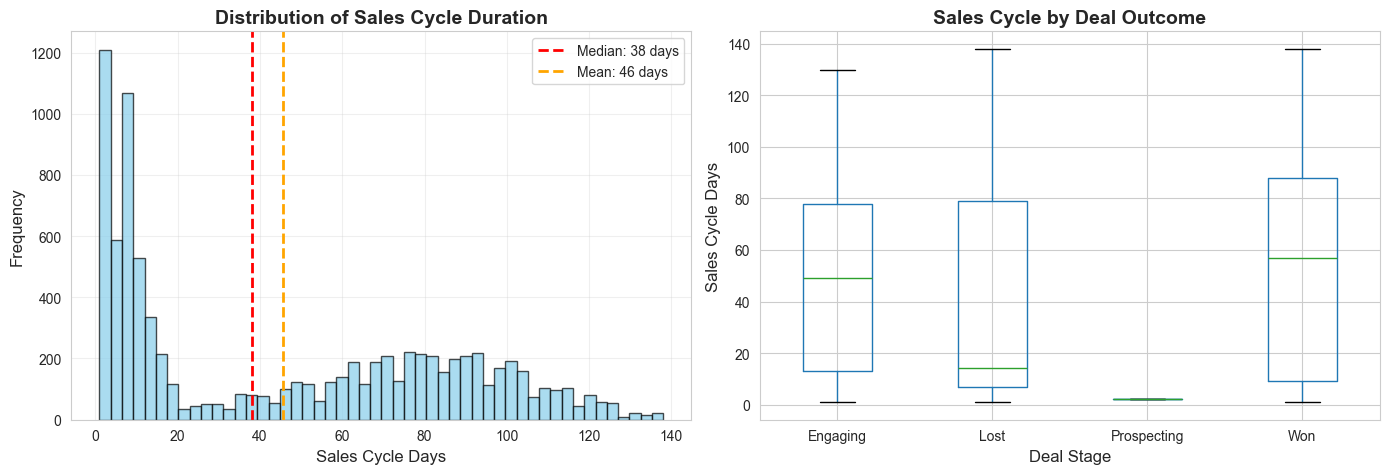


Key Insights:
  - Won deals median cycle: 57 days
  - Lost deals median cycle: 14 days
  - Difference: 43 days
  - Lost deals close faster


In [211]:
# Feature 1: Sales Cycle Days (Calendar days)
df['sales_cycle_days'] = (df['close_date'] - df['engage_date']).dt.days

print("Sales Cycle Duration Analysis:")
print("="*70)
print(df['sales_cycle_days'].describe())

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(df['sales_cycle_days'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(df['sales_cycle_days'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df["sales_cycle_days"].median():.0f} days')
ax1.axvline(df['sales_cycle_days'].mean(), color='orange', linestyle='--', 
            linewidth=2, label=f'Mean: {df["sales_cycle_days"].mean():.0f} days')
ax1.set_xlabel('Sales Cycle Days', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Sales Cycle Duration', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by deal stage
df.boxplot(column='sales_cycle_days', by='deal_stage', ax=ax2)
ax2.set_xlabel('Deal Stage', fontsize=12)
ax2.set_ylabel('Sales Cycle Days', fontsize=12)
ax2.set_title('Sales Cycle by Deal Outcome', fontsize=14, fontweight='bold')
plt.suptitle('') 

plt.tight_layout()
plt.show()

# Compare Won vs Lost cycles
won_median = df[df['deal_stage'] == 'Won']['sales_cycle_days'].median()
lost_median = df[df['deal_stage'] == 'Lost']['sales_cycle_days'].median()

print(f"\nKey Insights:")
print(f"  - Won deals median cycle: {won_median:.0f} days")
print(f"  - Lost deals median cycle: {lost_median:.0f} days")
print(f"  - Difference: {abs(won_median - lost_median):.0f} days")

if won_median < lost_median:
    print(f"  - Won deals close {((lost_median/won_median - 1)*100):.1f}% faster")
else:
    print(f"  - Lost deals close faster")

In [212]:
# Feature 2: Business Days in Sales Cycle
# Calculate business days (excluding weekends)
def calculate_business_days(row):
    """Calculate business days between two dates"""
    if pd.isna(row['engage_date']) or pd.isna(row['close_date']):
        return np.nan
    return len(pd.bdate_range(row['engage_date'], row['close_date']))

print("=================================================================")
df['business_days_in_cycle'] = df.apply(calculate_business_days, axis=1)

print("\nBusiness Days vs Calendar Days:")
print("="*70)
comparison_df = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std Dev'],
    'Calendar Days': [
        df['sales_cycle_days'].mean(),
        df['sales_cycle_days'].median(),
        df['sales_cycle_days'].std()
    ],
    'Business Days': [
        df['business_days_in_cycle'].mean(),
        df['business_days_in_cycle'].median(),
        df['business_days_in_cycle'].std()
    ]
})
print(comparison_df.to_string(index=False))

# Weekend proportion
weekend_impact = ((df['sales_cycle_days'] - df['business_days_in_cycle']) / 
                  df['sales_cycle_days']).mean() * 100
print(f"\nWeekend days account for ~{weekend_impact:.1f}% of sales cycles")

print("\nFEATURE CREATED SUCCESSFULLY")


Business Days vs Calendar Days:
 Metric  Calendar Days  Business Days
   Mean      45.686932      33.400568
 Median      38.000000      28.000000
Std Dev      40.240865      28.712856

Weekend days account for ~17.0% of sales cycles

FEATURE CREATED SUCCESSFULLY


Sales Cycle Category Distribution:
 Category  Count  Percentage
    Quick   4223       47.99
 Extended   2017       22.92
     Long   1601       18.19
 Standard    959       10.90
Very_Long      0        0.00


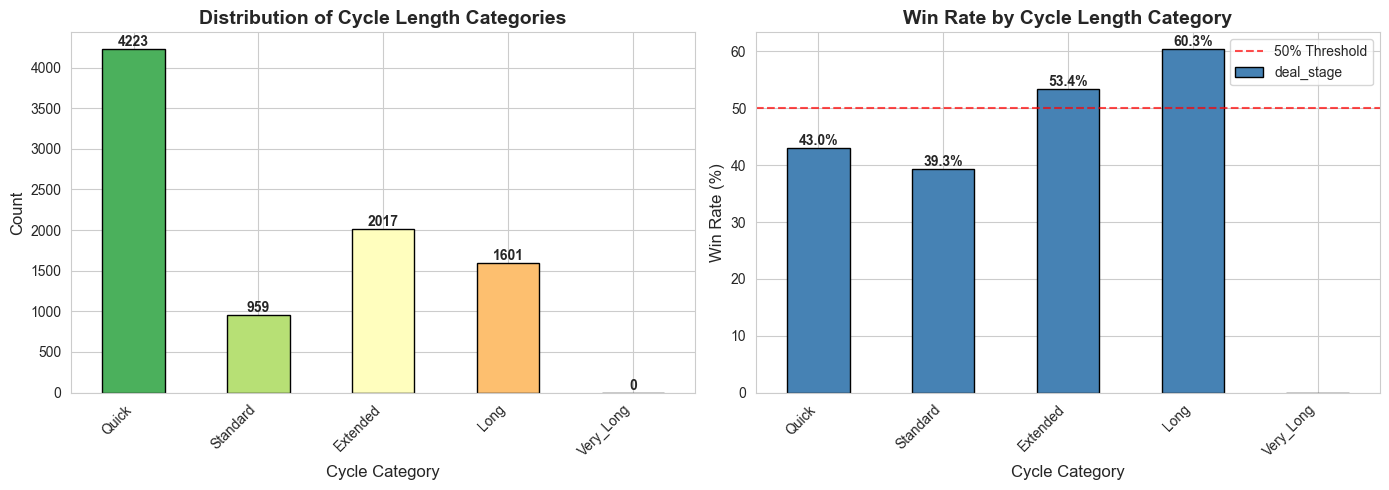


Key Finding:
  - Highest win rate: Long (60.3%)
  - Lowest win rate: Standard (39.3%)

FEATURE CREATED SUCCESSFULLY


In [213]:
# Feature 3: Cycle Length Categories
# Bin sales cycles into categories based on business rules

df['cycle_length_category'] = pd.cut(
    df['sales_cycle_days'],
    bins=[0, 30, 60, 90, 180, float('inf')],
    labels=['Quick', 'Standard', 'Extended', 'Long', 'Very_Long']
)

print("Sales Cycle Category Distribution:")
print("="*70)

category_df = pd.DataFrame({
    'Category': df['cycle_length_category'].value_counts().index,
    'Count': df['cycle_length_category'].value_counts().values,
    'Percentage': (df['cycle_length_category'].value_counts(normalize=True) * 100).values.round(2)
})
print(category_df.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
category_counts = df['cycle_length_category'].value_counts().sort_index()
colors = sns.color_palette('RdYlGn_r', len(category_counts))
category_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Distribution of Cycle Length Categories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cycle Category', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for i, v in enumerate(category_counts.values):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Win rate by category
win_rate_by_category = df.groupby('cycle_length_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
).sort_index()

win_rate_by_category.plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black')
ax2.set_title('Win Rate by Cycle Length Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cycle Category', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% Threshold')
ax2.legend()

# Add value labels
for i, v in enumerate(win_rate_by_category.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Finding:")
best_category = win_rate_by_category.idxmax()
worst_category = win_rate_by_category.idxmin()
print(f"  - Highest win rate: {best_category} ({win_rate_by_category.max():.1f}%)")
print(f"  - Lowest win rate: {worst_category} ({win_rate_by_category.min():.1f}%)")
print(f"\nFEATURE CREATED SUCCESSFULLY")

#### 5. Date Component Features (Seasonality)

#### Business Context:
In sales, the pattern often is time based like sales are urgently closed before a months end date, friday is usually when a deal closes due to weekly deadline, and companies rush to meet yearly target which means usually Q4 has the most close rate. 

#### Features to Create:
1. **`engage_month`**: Month of initial engagement (1-12)
2. **`engage_quarter`**: Business quarter (Q1-Q4)
3. **`engage_year`**: Year of engagement
4. **`engage_day_of_week`**: Day of week (0=Monday, 6=Sunday)
5. **`engage_week_of_year`**: ISO week number (1-52)

#### Why These Features Matter:
These features capture trend in sales based on seasonality and identifies the best time to engage in prospecting.

In [214]:
# Extract date components from engage_date
print("Temporal Components from Engagement Date")
print("="*70)

df['engage_month'] = df['engage_date'].dt.month
df['engage_quarter'] = df['engage_date'].dt.quarter
df['engage_year'] = df['engage_date'].dt.year
df['engage_day_of_week'] = df['engage_date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['engage_week_of_year'] = df['engage_date'].dt.isocalendar().week

print("Feature created successfully")
print(f"\nNew features created:")
temporal_features = [
    'engage_month', 'engage_quarter', 'engage_year', 'engage_day_of_week',
    'engage_week_of_year'
]
for i, feat in enumerate(temporal_features, 1):
    print(f"  {i}. {feat}")

Temporal Components from Engagement Date
Feature created successfully

New features created:
  1. engage_month
  2. engage_quarter
  3. engage_year
  4. engage_day_of_week
  5. engage_week_of_year


Seasonal Pattern Analysis:


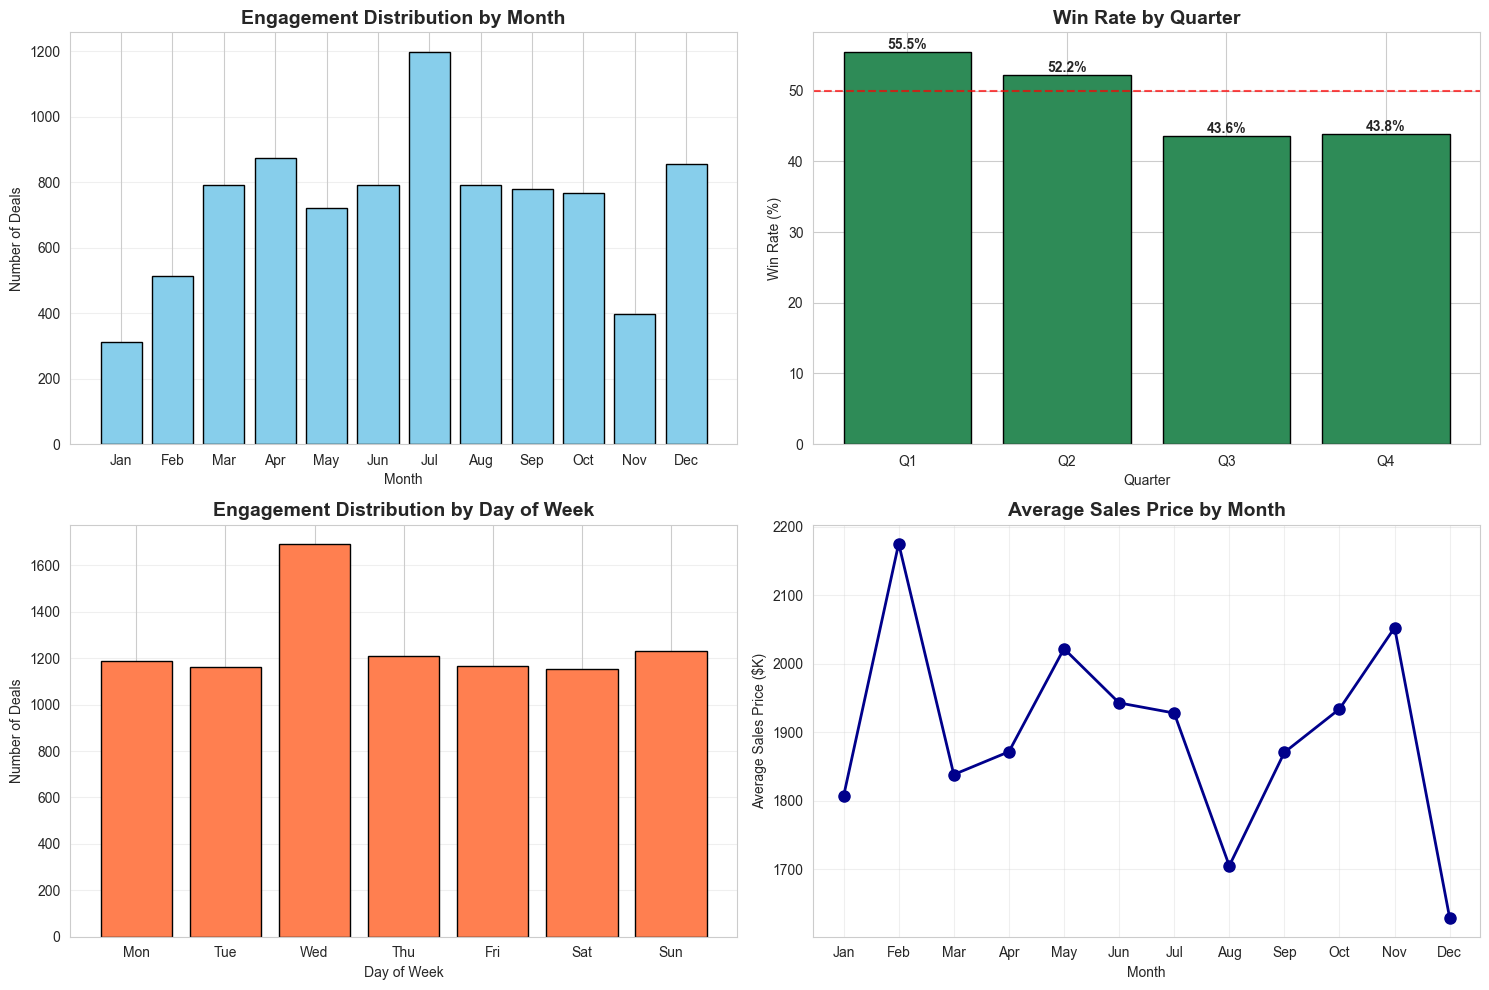


Seasonal Insights:
  - Best quarter for wins: Q1 (55.5% win rate)
  - Busiest engagement month: Jul (1198 deals)
  - Weekend engagements: 27.1% of total


In [215]:
# Analyze seasonal patterns
print("Seasonal Pattern Analysis:")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Deals by Month
month_counts = df['engage_month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(month_names, month_counts.values, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Engagement Distribution by Month', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Deals')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Win Rate by Quarter
quarter_win_rate = df.groupby('engage_quarter')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
axes[0, 1].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarter_win_rate.values, 
               color='seagreen', edgecolor='black')
axes[0, 1].set_title('Win Rate by Quarter', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quarter')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(quarter_win_rate.values):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Deals by Day of Week
dow_counts = df['engage_day_of_week'].value_counts().sort_index()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(dow_names, dow_counts.values, color='coral', edgecolor='black')
axes[1, 0].set_title('Engagement Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Deals')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Average Sales Price by Month
month_avg_price = df.groupby('engage_month')['sales_price'].mean()
axes[1, 1].plot(month_names, month_avg_price.values, marker='o', 
                linewidth=2, markersize=8, color='darkblue')
axes[1, 1].set_title('Average Sales Price by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Sales Price ($K)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\nSeasonal Insights:")
best_quarter = quarter_win_rate.idxmax()
print(f"  - Best quarter for wins: Q{best_quarter} ({quarter_win_rate.max():.1f}% win rate)")

busiest_month = month_counts.idxmax()
print(f"  - Busiest engagement month: {month_names[busiest_month-1]} ({month_counts.max()} deals)")

weekend_deals = dow_counts.loc[5:].sum() if 5 in dow_counts.index or 6 in dow_counts.index else 0
weekend_pct = (weekend_deals / dow_counts.sum()) * 100
print(f"  - Weekend engagements: {weekend_pct:.1f}% of total")

#### Summary of Temporal Features
A total of 8 features were created based on time based properties. The following are the features:

1. **sales_cycle_days** - Calendar days from engagement to deal close
2. **business_days_in_cycle** - Working days only (excludes weekends)
3. **cycle_length_category** - Binned categories (Quick to Very_Long)
4. **engage_month** - Month of engagement (1-12)
5. **engage_quarter** - Business quarter (1-4)
6. **engage_year** - Year of engagement
7. **engage_day_of_week** - Day of week (0-6)
8. **engage_week_of_year** - ISO week number (1-52)

---
---

#### Feature engineering - Part 2: Numerical features (Ratio and transformations)
#### 6. Company Efficiency and Size Ratios

#### Business Context:
Numerical features such as number of employees and revenue needs to be transformed into ratios that can capture meaningful business relationships. A high revenue low employee count indicates high revenue per employee that is a sign of efficiency. The company's age shows maturity and the deal size relative to the company shows how significant the deal is. 

**Important Note on Units:**
- Revenue is in **millions of dollars** (e.g., 718.62 = $718.62M)
- Close_value and sales_price are in **thousands of dollars** (e.g., 1054.0 = $1,054K)
- For ratio calculations, revenue is converted to thousands (multiply by 1000) to match units


#### Features to Create:
1. **`revenue_per_employee`**: Revenue divided by employees for measurement of operational efficiency
2. **`company_age`**: Years since establishment that shows maturity and stability
3. **`sales_price_per_employee`**: Sales price per employee normalizes deal size by company scale
4. **`revenue_to_price_ratio`**: Revenue divided by sales price shows deal significance

#### Justification for the features:
These ratio features normalize raw values by company context. For example a 100K deal is significant for a small company but trivial for a large enterprise. Revenue per employee indicates operational efficiency and profitability. These features help models understand relative magnitude rather than absolute values.

Efficiency Ratio Features

Revenue per Employee Statistics (in thousands $):
count    8800.000000
mean      494.179163
std       173.767298
min       273.103056
25%       378.716925
50%       495.204558
75%       546.990826
max      1181.802575
Name: revenue_per_employee, dtype: float64


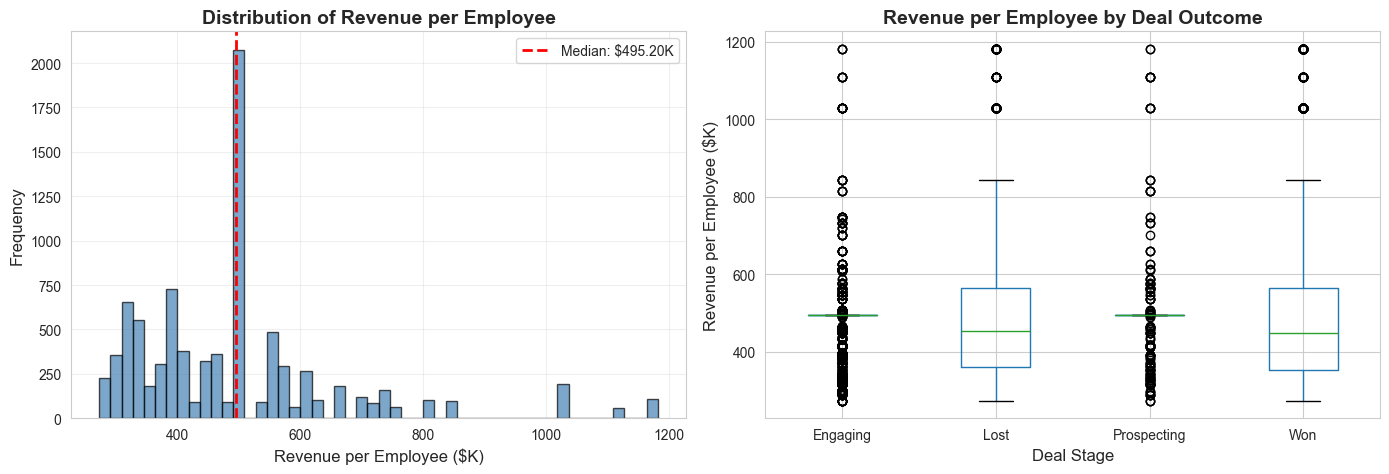


FEATURE CREATED SUCCESSFULLY


In [216]:
# Feature 4: Revenue per Employee
# Measures operational efficiency - higher values indicate more productive workforce
print("Efficiency Ratio Features")
print("="*70)

# Convert revenue from millions to thousands to match other financial metrics
# Revenue is in millions, so multiply by 1000 to get thousands
df['revenue_per_employee'] = (df['revenue'] * 1000) / df['employees']

print("\nRevenue per Employee Statistics (in thousands $):")
print(df['revenue_per_employee'].describe())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax1.hist(df['revenue_per_employee'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['revenue_per_employee'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: ${df["revenue_per_employee"].median():.2f}K')
ax1.set_xlabel('Revenue per Employee ($K)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Revenue per Employee', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot by deal stage
df.boxplot(column='revenue_per_employee', by='deal_stage', ax=ax2)
ax2.set_xlabel('Deal Stage', fontsize=12)
ax2.set_ylabel('Revenue per Employee ($K)', fontsize=12)
ax2.set_title('Revenue per Employee by Deal Outcome', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nFEATURE CREATED SUCCESSFULLY")

Company Age Feature

Company Age Statistics (as of 2017):
count    8800.000000
mean       21.270795
std         8.428892
min         0.000000
25%        17.000000
50%        20.000000
75%        27.000000
max        38.000000
Name: company_age, dtype: float64


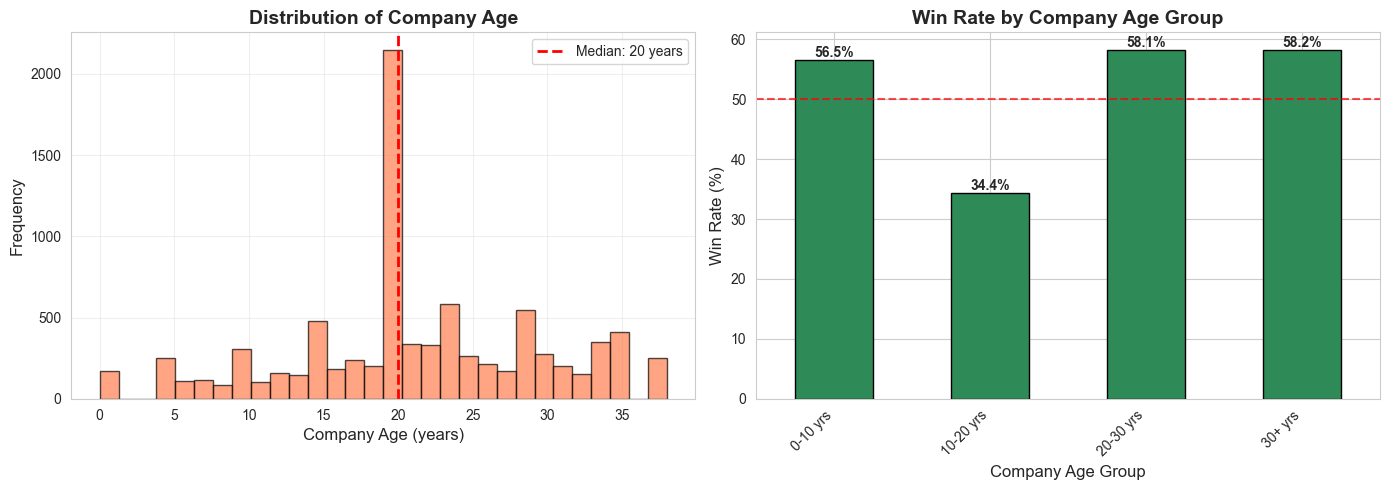


Key Insights:
  - Average company age: 21.3 years
  - Oldest company: 38 years
  - Newest company: 0 years

FEATURE CREATED SUCCESSFULLY


In [217]:
# Feature 5: Company Age
# Calculate years since establishment
print("Company Age Feature")
print("="*70)

# Use engagement year (when prospect was first contacted)
current_year = df['engage_year'].max()
df['company_age'] = current_year - df['year_established']

print(f"\nCompany Age Statistics (as of {current_year}):")
print(df['company_age'].describe())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax1.hist(df['company_age'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax1.axvline(df['company_age'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df["company_age"].median():.0f} years')
ax1.set_xlabel('Company Age (years)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Company Age', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Win rate by age group
age_bins = [0, 10, 20, 30, 40]
age_labels = ['0-10 yrs', '10-20 yrs', '20-30 yrs', '30+ yrs']
df['age_group_temp'] = pd.cut(df['company_age'], bins=age_bins, labels=age_labels)
win_rate_by_age = df.groupby('age_group_temp')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)

win_rate_by_age.plot(kind='bar', ax=ax2, color='seagreen', edgecolor='black')
ax2.set_title('Win Rate by Company Age Group', fontsize=14, fontweight='bold')
ax2.set_xlabel('Company Age Group', fontsize=12)
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(win_rate_by_age.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Drop temporary column
df.drop('age_group_temp', axis=1, inplace=True)

print("\nKey Insights:")
print(f"  - Average company age: {df['company_age'].mean():.1f} years")
print(f"  - Oldest company: {df['company_age'].max()} years")
print(f"  - Newest company: {df['company_age'].min()} years")

print("\nFEATURE CREATED SUCCESSFULLY")

Creating Deal Context Ratio Features

Deal Context Ratios Statistics:
       sales_price_per_employee  revenue_to_price_ratio
count               7320.000000             7320.000000
mean                   4.734241            15215.055930
std                   38.457585            35272.692803
min                    0.001604                0.828165
25%                    0.046365              594.218182
50%                    0.205649             2300.027372
75%                    0.803425             9379.472727
max                  609.111111           212691.454545

Note: Using sales_price (quoted price) instead of close_value (actual outcome)
Note: Revenue converted from millions to thousands for ratio calculations
Note: Replaced infinite values with NaN (from divide by zero)


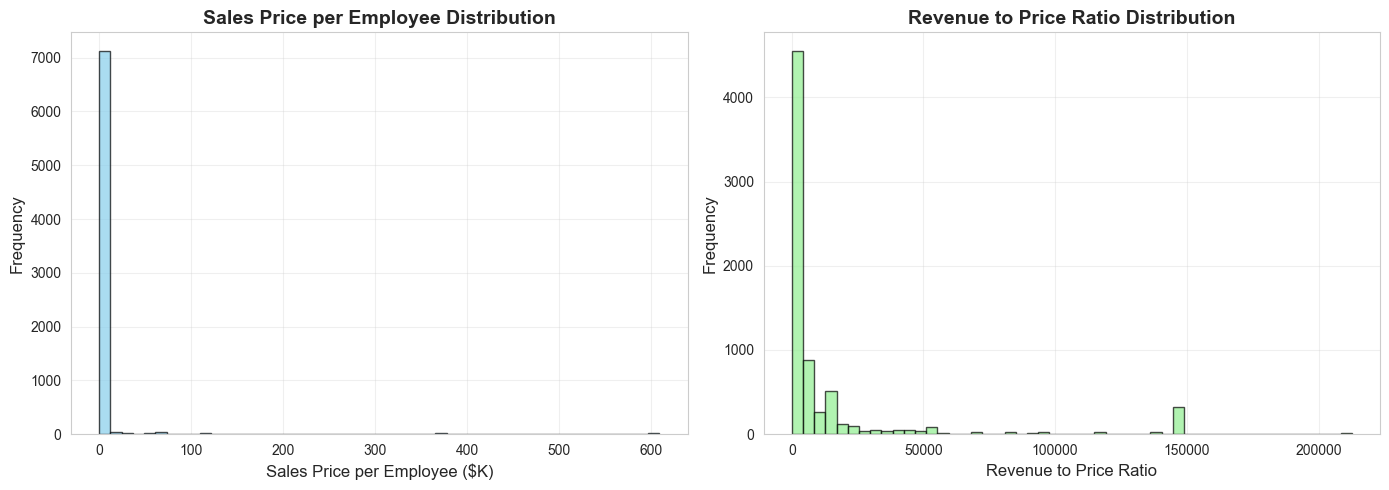


Key Insights:
  - Average sales price per employee: $4.73K
  - Average revenue to price ratio: 15215.06x

2 FEATURES CREATED SUCCESSFULLY


In [ ]:
# Features 6-7: Deal Context Ratios 
# These features normalize deal size by company characteristics
print("Creating Deal Context Ratio Features")
print("="*70)

# Feature 6: Sales price per employee - normalizes deal size by company size
# sales_price is the quoted/expected price (set before deal outcome)
df['sales_price_per_employee'] = df['sales_price'] / df['employees']

# Feature 7: Revenue to price ratio - shows deal significance relative to company revenue
# Convert revenue from millions to thousands to match sales_price units
df['revenue_to_price_ratio'] = (df['revenue'] * 1000) / df['sales_price']
df['revenue_to_price_ratio'] = df['revenue_to_price_ratio'].replace([np.inf, -np.inf], np.nan)

print("\nDeal Context Ratios Statistics:")
print("="*70)
ratio_features = ['sales_price_per_employee', 'revenue_to_price_ratio']
print(df[ratio_features].describe())

print(f"\nNote: Using sales_price (quoted price) instead of close_value (actual outcome)")
print(f"Note: Revenue converted from millions to thousands for ratio calculations")
print(f"Note: Replaced infinite values with NaN (from divide by zero)")

# Visualize the two ratios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sales price per employee
axes[0].hist(df['sales_price_per_employee'].dropna(), bins=50, edgecolor='black', 
             alpha=0.7, color='skyblue')
axes[0].set_xlabel('Sales Price per Employee ($K)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Sales Price per Employee Distribution', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Revenue to price ratio
axes[1].hist(df['revenue_to_price_ratio'].dropna(), bins=50, edgecolor='black', 
             alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Revenue to Price Ratio', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Revenue to Price Ratio Distribution', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Average sales price per employee: ${df['sales_price_per_employee'].mean():.2f}K")
print(f"  - Average revenue to price ratio: {df['revenue_to_price_ratio'].mean():.2f}x")

print("\n2 FEATURES CREATED SUCCESSFULLY")

#### 7. Log Transformations for Skewed Distributions

#### Business Context:
Many numerical features in business data follow right-skewed distributions where most values are small but a few are very large. Revenue, employees, and sales_price often have this pattern. Log transformation compresses large values and spreads small values, making distributions more normal and reducing the impact of outliers.

#### Features to Create:
1. **`log_revenue`**: Log of revenue - handles right-skewed revenue distribution
2. **`log_employees`**: Log of employee count - normalizes company size
3. **`log_sales_price`**: Log of sales price - reduces impact of mega-deals
4. **`log_sales_cycle_days`**: Log of sales cycle - normalizes time distribution

#### Justification for the features:
Log transformations improve model performance by making distributions more Gaussian and reducing the influence of extreme outliers. Many ML algorithms assume normally distributed features. Using log1p ensures we handle zero values correctly.

Creating Log Transformed Features

Log Transformed Features Statistics:
       log_revenue  log_employees  log_sales_price  log_sales_cycle_days
count  8800.000000    8800.000000      7320.000000           8800.000000
mean      7.423476       8.176806         6.601906              3.207524
std       1.526315       1.558308         1.613352              1.309094
min       1.711995       2.302585         4.025352              0.693147
25%       6.578723       7.370860         6.311735              2.197225
50%       7.684775       8.420903         7.000334              3.663562
75%       8.757134       9.533148         8.129764              4.418841
max       9.367261      10.442580        10.195000              4.934474


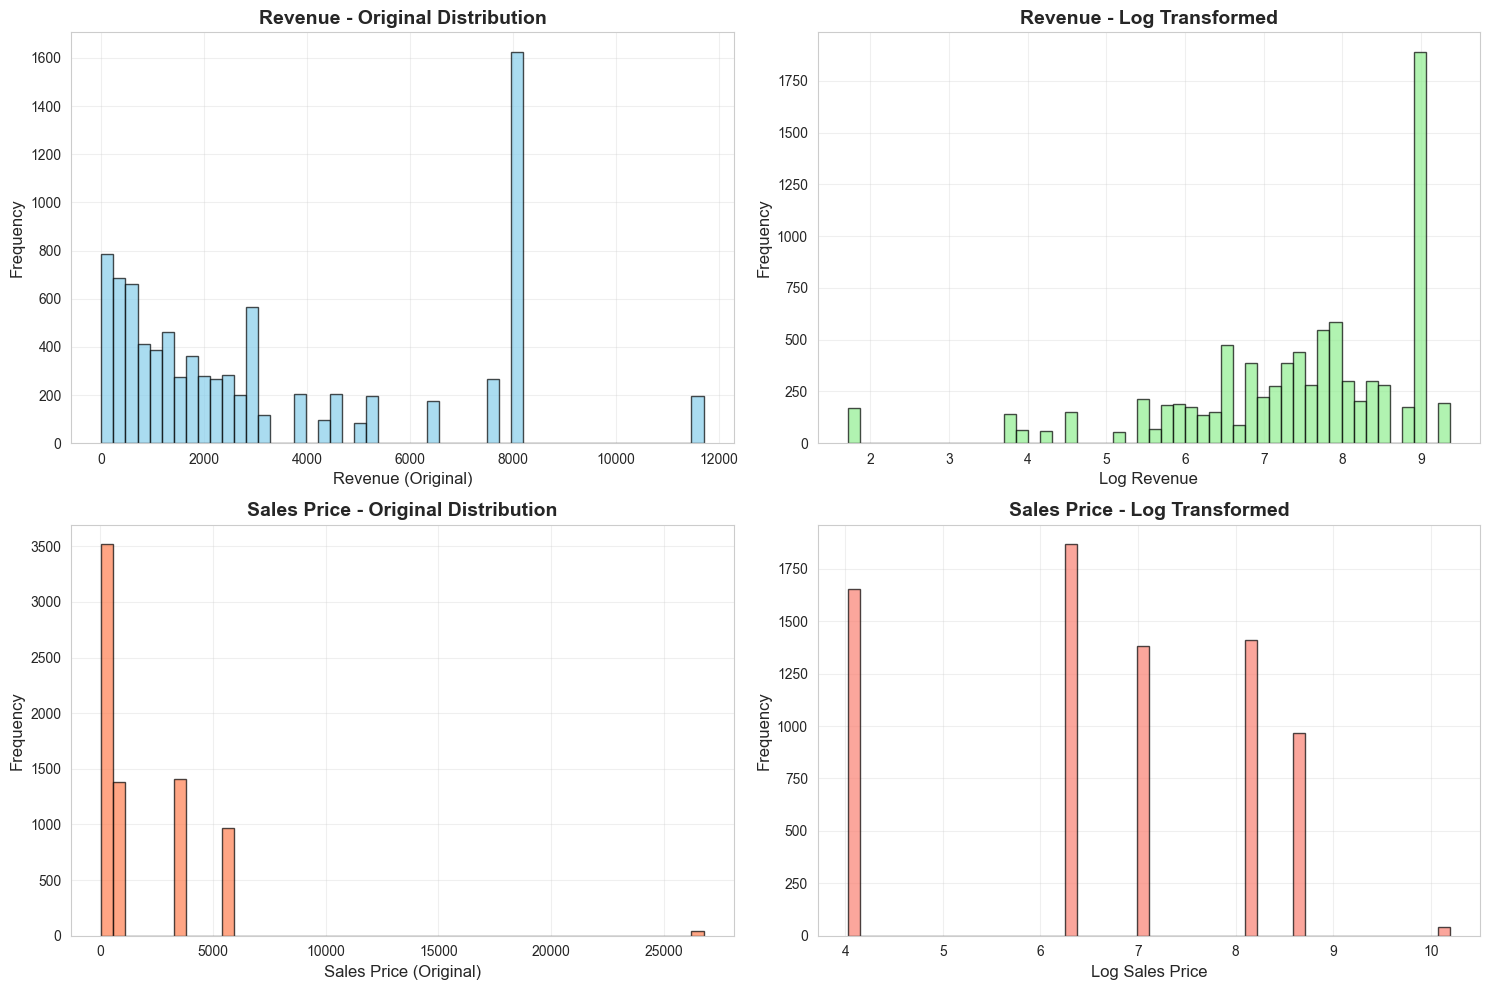


Key Insights:
  - Log transformation reduces skewness in distributions
  - Original revenue: highly right-skewed
  - Log revenue: more normal distribution
  - This helps tree-based and linear models perform better

4 FEATURES CREATED SUCCESSFULLY


In [ ]:
# Features 8-11: Log Transformations 
# Apply log1p (log(1+x)) to handle zero values
print("Creating Log Transformed Features")
print("="*70)

# Log transformations using log1p to handle zeros
df['log_revenue'] = np.log1p(df['revenue'])
df['log_employees'] = np.log1p(df['employees'])
df['log_sales_price'] = np.log1p(df['sales_price'])  
df['log_sales_cycle_days'] = np.log1p(df['sales_cycle_days'])

print("\nLog Transformed Features Statistics:")
print("="*70)
log_features = ['log_revenue', 'log_employees', 'log_sales_price', 'log_sales_cycle_days']
print(df[log_features].describe())

# Visualize before and after transformation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Revenue: Original vs Log
axes[0, 0].hist(df['revenue'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Revenue (Original)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Revenue - Original Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(df['log_revenue'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Log Revenue', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Revenue - Log Transformed', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Sales Price: Original vs Log
axes[1, 0].hist(df['sales_price'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Sales Price (Original)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Sales Price - Original Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(df['log_sales_price'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[1, 1].set_xlabel('Log Sales Price', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Sales Price - Log Transformed', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Log transformation reduces skewness in distributions")
print("  - Original revenue: highly right-skewed")
print("  - Log revenue: more normal distribution")
print("  - This helps tree-based and linear models perform better")

print("\n4 FEATURES CREATED SUCCESSFULLY")

#### 8. Binning and Categorization

#### Business Context:
Continuous numerical features can be binned into categories to capture non-linear relationships and business thresholds. Companies are often segmented as Small/Medium/Large/Enterprise based on revenue and employee count. This discretization helps models identify patterns specific to each segment.

#### Features to Create:
1. **`revenue_category`**: Small/Medium/Large/Enterprise based on revenue quartiles
2. **`employee_size_category`**: Startup/SMB/Mid-Market/Enterprise based on employee count
3. **`sales_price_category`**: Budget/Standard/Premium/Enterprise based on sales_price quartiles


#### Justification for the features:
Binning creates categorical features that capture business segments. A linear relationship may not exist across the entire range, but patterns within segments may be strong. For example, sales strategies differ for small vs enterprise customers.

Creating Binned Category Features

Category Distributions:

Revenue Category:
revenue_category
Small         2235
Medium        2171
Large         2238
Enterprise    2156
Name: count, dtype: int64

Employee Size Category:
employee_size_category
Startup       2280
SMB           2159
Mid-Market    2197
Enterprise    2164
Name: count, dtype: int64

Sales Price Category:
sales_price_category
Budget        3517
Standard      1383
Premium       1412
Enterprise    1008
Name: count, dtype: int64


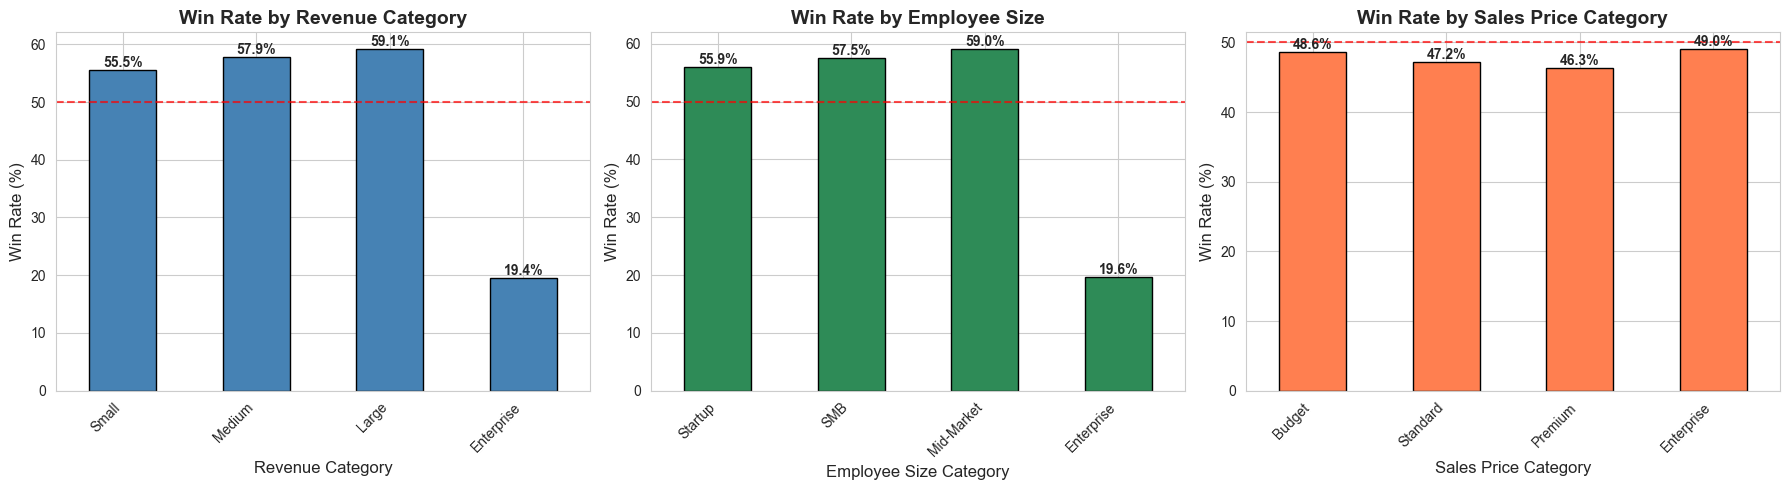


Key Insights:
  - Best revenue segment: Large (59.1% win rate)
  - Best employee segment: Mid-Market (59.0% win rate)
  - Best sales price segment: Enterprise (49.0% win rate)

3 FEATURES CREATED SUCCESSFULLY


In [220]:
# Features 12-14: Binning and Categorization
# Create categorical segments based on numerical thresholds
print("Creating Binned Category Features")
print("="*70)

# Feature 12: Revenue categories based on quartiles
revenue_quartiles = df['revenue'].quantile([0.25, 0.50, 0.75]).values
df['revenue_category'] = pd.cut(
    df['revenue'],
    bins=[0, revenue_quartiles[0], revenue_quartiles[1], revenue_quartiles[2], float('inf')],
    labels=['Small', 'Medium', 'Large', 'Enterprise']
)

# Feature 13: Employee size categories
employee_quartiles = df['employees'].quantile([0.25, 0.50, 0.75]).values
df['employee_size_category'] = pd.cut(
    df['employees'],
    bins=[0, employee_quartiles[0], employee_quartiles[1], employee_quartiles[2], float('inf')],
    labels=['Startup', 'SMB', 'Mid-Market', 'Enterprise']
)

# Feature 14: Sales price categories 
# Filter out NaN values for quartile calculation
sales_price_quartiles = df['sales_price'].dropna().quantile([0.25, 0.50, 0.75]).values
df['sales_price_category'] = pd.cut(
    df['sales_price'],
    bins=[0, sales_price_quartiles[0], sales_price_quartiles[1], sales_price_quartiles[2], float('inf')],
    labels=['Budget', 'Standard', 'Premium', 'Enterprise']
)

print("\nCategory Distributions:")
print("="*70)
print("\nRevenue Category:")
print(df['revenue_category'].value_counts().sort_index())

print("\nEmployee Size Category:")
print(df['employee_size_category'].value_counts().sort_index())

print("\nSales Price Category:")
print(df['sales_price_category'].value_counts().sort_index())

# Visualize win rates by categories
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Win rate by revenue category
win_rate_revenue = df.groupby('revenue_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_revenue.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Win Rate by Revenue Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Revenue Category', fontsize=12)
axes[0].set_ylabel('Win Rate (%)', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_revenue.values):
    axes[0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Win rate by employee size
win_rate_employees = df.groupby('employee_size_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_employees.plot(kind='bar', ax=axes[1], color='seagreen', edgecolor='black')
axes[1].set_title('Win Rate by Employee Size', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Employee Size Category', fontsize=12)
axes[1].set_ylabel('Win Rate (%)', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_employees.values):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Win rate by sales price
win_rate_price = df.groupby('sales_price_category')['deal_stage'].apply(
    lambda x: (x == 'Won').mean() * 100
)
win_rate_price.plot(kind='bar', ax=axes[2], color='coral', edgecolor='black')
axes[2].set_title('Win Rate by Sales Price Category', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Sales Price Category', fontsize=12)
axes[2].set_ylabel('Win Rate (%)', fontsize=12)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].axhline(y=50, color='red', linestyle='--', alpha=0.7)
for i, v in enumerate(win_rate_price.values):
    axes[2].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  - Best revenue segment: {win_rate_revenue.idxmax()} ({win_rate_revenue.max():.1f}% win rate)")
print(f"  - Best employee segment: {win_rate_employees.idxmax()} ({win_rate_employees.max():.1f}% win rate)")
print(f"  - Best sales price segment: {win_rate_price.idxmax()} ({win_rate_price.max():.1f}% win rate)")

print("\n3 FEATURES CREATED SUCCESSFULLY")

#### 9. Polynomial Features for Non-Linear Relationships

#### Business Context:
Some relationships in business are non-linear. For example, very long sales cycles may have an exponentially lower win rates rather than linearly lower. Polynomial features capture these non-linear patterns by creating squared or interaction terms.

#### Features to Create:
1. **`revenue_squared`**: Revenue squared captures quadratic relationship
2. **`employees_squared`**: Employees squared non-linear company size effects
3. **`sales_cycle_squared`**: Sales cycle squared diminishing returns over time

#### Justification for the features:
Polynomial features allow linear models to capture non-linear relationships. While tree-based models handle non-linearity naturally, linear models and neural networks benefit from explicit polynomial terms. This is especially useful for relationships with accelerating or decelerating effects.

Polynomial Features

Polynomial Features Statistics:
       revenue_squared  employees_squared  sales_cycle_squared
count     8.800000e+03       8.800000e+03          8800.000000
mean      1.575533e-01       9.378371e-02             0.194625
std       2.268239e-01       1.680701e-01             0.233130
min       1.506212e-07       6.889706e-08             0.000053
25%       3.773750e-03       2.144948e-03             0.003361
50%       3.453708e-02       1.753184e-02             0.075824
75%       2.951127e-01       1.621960e-01             0.353077
max       1.000000e+00       1.000000e+00             1.000000


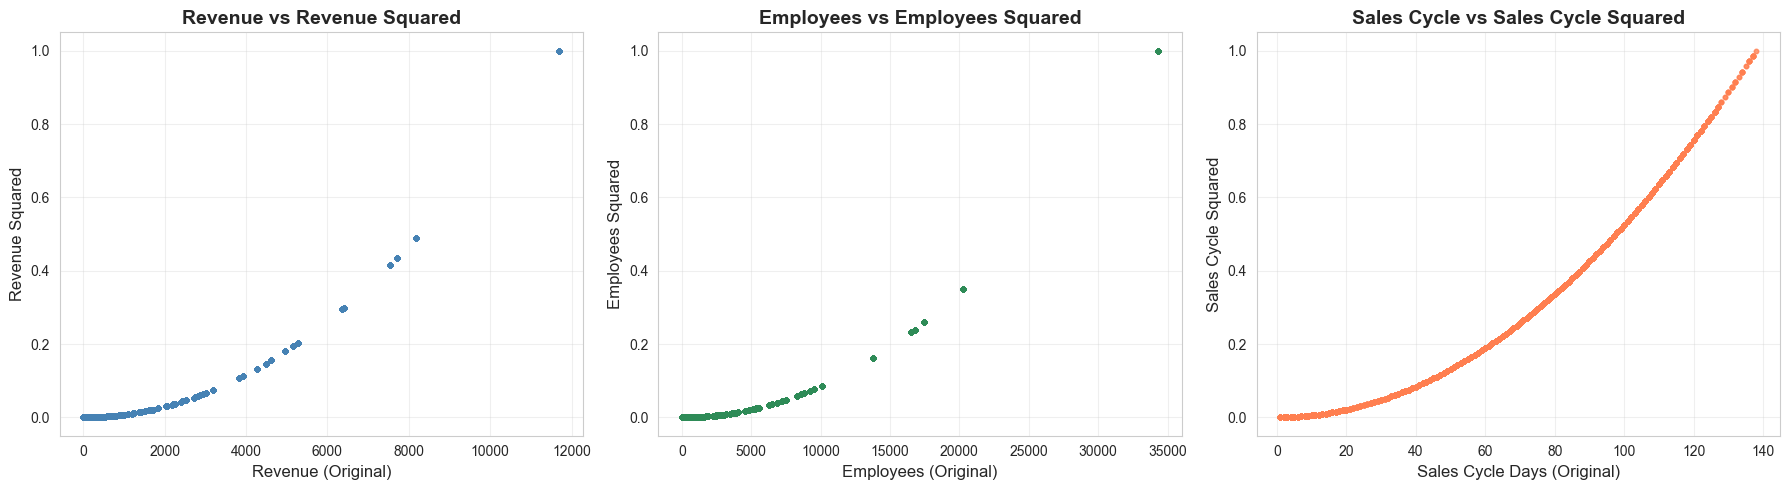


Key Insights:
  - Polynomial features capture non-linear patterns
  - Squared terms amplify differences between small and large values
  - Normalized before squaring to prevent numerical overflow

3 FEATURES CREATED SUCCESSFULLY


In [221]:
# Features 16-18: Polynomial Features
# Create squared terms to capture non-linear relationships
print("Polynomial Features")
print("="*70)

# Normalize values before squaring to prevent extremely large numbers
df['revenue_normalized'] = df['revenue'] / df['revenue'].max()
df['employees_normalized'] = df['employees'] / df['employees'].max()
df['sales_cycle_normalized'] = df['sales_cycle_days'] / df['sales_cycle_days'].max()

# Create squared features
df['revenue_squared'] = df['revenue_normalized'] ** 2
df['employees_squared'] = df['employees_normalized'] ** 2
df['sales_cycle_squared'] = df['sales_cycle_normalized'] ** 2

# Drop temporary normalized columns
df.drop(['revenue_normalized', 'employees_normalized', 'sales_cycle_normalized'], 
        axis=1, inplace=True)

print("\nPolynomial Features Statistics:")
print("="*70)
poly_features = ['revenue_squared', 'employees_squared', 'sales_cycle_squared']
print(df[poly_features].describe())

# Visualize relationship between original and squared features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Revenue vs Revenue Squared
axes[0].scatter(df['revenue'], df['revenue_squared'], alpha=0.5, s=10, color='steelblue')
axes[0].set_xlabel('Revenue (Original)', fontsize=12)
axes[0].set_ylabel('Revenue Squared', fontsize=12)
axes[0].set_title('Revenue vs Revenue Squared', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Employees vs Employees Squared
axes[1].scatter(df['employees'], df['employees_squared'], alpha=0.5, s=10, color='seagreen')
axes[1].set_xlabel('Employees (Original)', fontsize=12)
axes[1].set_ylabel('Employees Squared', fontsize=12)
axes[1].set_title('Employees vs Employees Squared', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Sales Cycle vs Sales Cycle Squared
axes[2].scatter(df['sales_cycle_days'], df['sales_cycle_squared'], alpha=0.5, s=10, color='coral')
axes[2].set_xlabel('Sales Cycle Days (Original)', fontsize=12)
axes[2].set_ylabel('Sales Cycle Squared', fontsize=12)
axes[2].set_title('Sales Cycle vs Sales Cycle Squared', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("  - Polynomial features capture non-linear patterns")
print("  - Squared terms amplify differences between small and large values")
print("  - Normalized before squaring to prevent numerical overflow")

print("\n3 FEATURES CREATED SUCCESSFULLY")

#### Summary of Numerical Features

A total of 14 numerical features were created through ratios, transformations, binning, and polynomial terms. 


**Ratio Features (4 features):**
1. **revenue_per_employee** - Operational efficiency measure
2. **company_age** - Years since establishment
3. **sales_price_per_employee** - Deal size normalized by company scale 
4. **revenue_to_price_ratio** - Deal significance relative to revenue 

**Log Transformations (4 features):**

5. **log_revenue** - Log transformed revenue
6. **log_employees** - Log transformed employee count
7. **log_sales_price** - Log transformed sales price
8. **log_sales_cycle_days** - Log transformed sales cycle

**Binned Categories (3 features):**

9. **revenue_category** - Small/Medium/Large/Enterprise
10. **employee_size_category** - Startup/SMB/Mid-Market/Enterprise
11. **sales_price_category** - Budget/Standard/Premium/Enterprise 

**Polynomial Features (3 features):**

12. **revenue_squared** - Revenue squared term
13. **employees_squared** - Employees squared term
14. **sales_cycle_squared** - Sales cycle squared term

**Total Numerical Features: 14**
